In [13]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

## RMSD Calculation

In [16]:
import pandas as pd

#Read all the trajectories
dna_101_ku04amp01_model0= mda.Universe('molecular_dynamics/dna_sequence_101_peptide_model_0/sys_prod/prod_start.pdb', 'molecular_dynamics/dna_sequence_101_peptide_model_0/sys_prod/prod_dna_sequence_101_peptide_model_0_compact_compact.xtc')

dna_72_ku04amp01_model0= mda.Universe('molecular_dynamics/dna_sequence_72_peptide_model_0/sys_prod/prod_start.pdb', 'molecular_dynamics/dna_sequence_72_peptide_model_0/sys_prod/prod_dna_sequence_72_peptide_model_0_compact_compact.xtc')

sims = {'72':dna_72_ku04amp01_model0, '101':dna_101_ku04amp01_model0}



  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

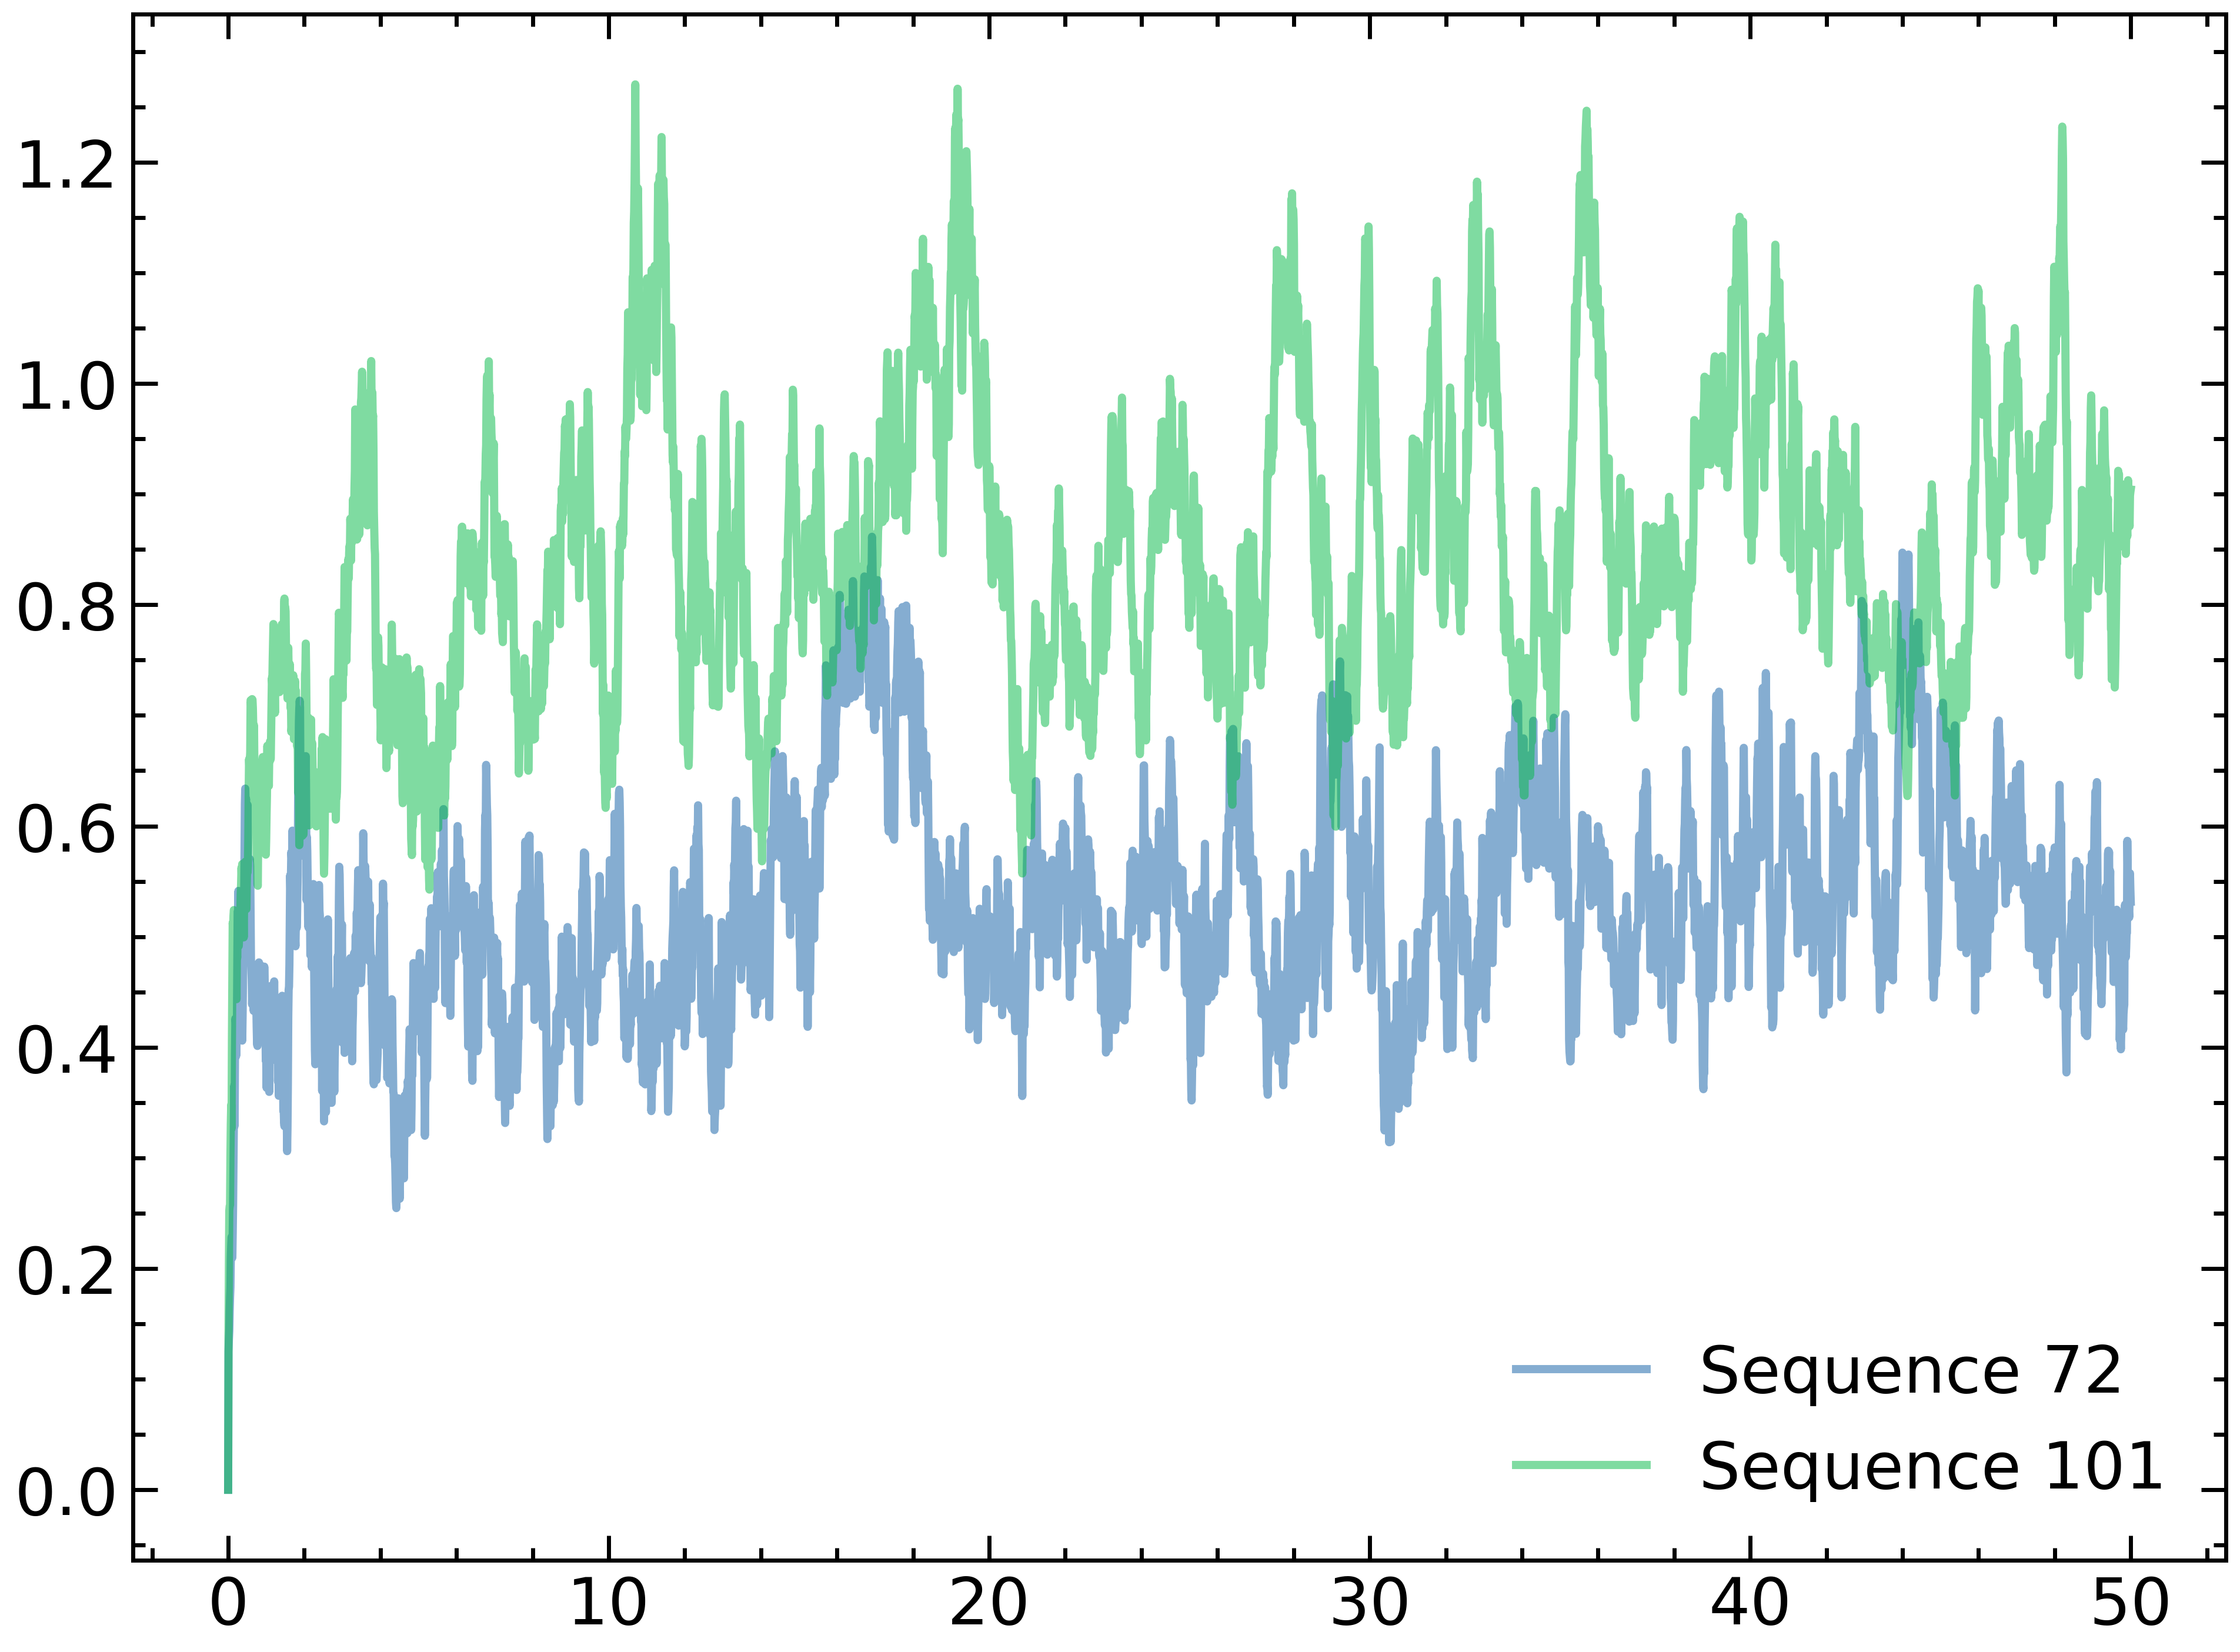

In [17]:
from MDAnalysis.analysis import rms

dfs = {}

for key, value in sims.items():
    R = rms.RMSD(value,  # universe to align
        value,  # reference universe or atomgroup
        select='nucleic',  # group to superimpose and calculate RMSD
        ref_frame=0)  # frame index of the reference

    R.run(verbose=True)
    times = R.results.rmsd[:,1]
    rmsd = R.results.rmsd[:,2]
    plt.plot(times/1000, rmsd/10, alpha=0.5, label=f'Sequence {key}')
    df_rmsd = pd.DataFrame(np.vstack((times, rmsd)).T, columns=["rmsd time", "rmsd"])
    dfs[key] = df_rmsd

plt.legend()


## Radius of Gyration Calculation

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

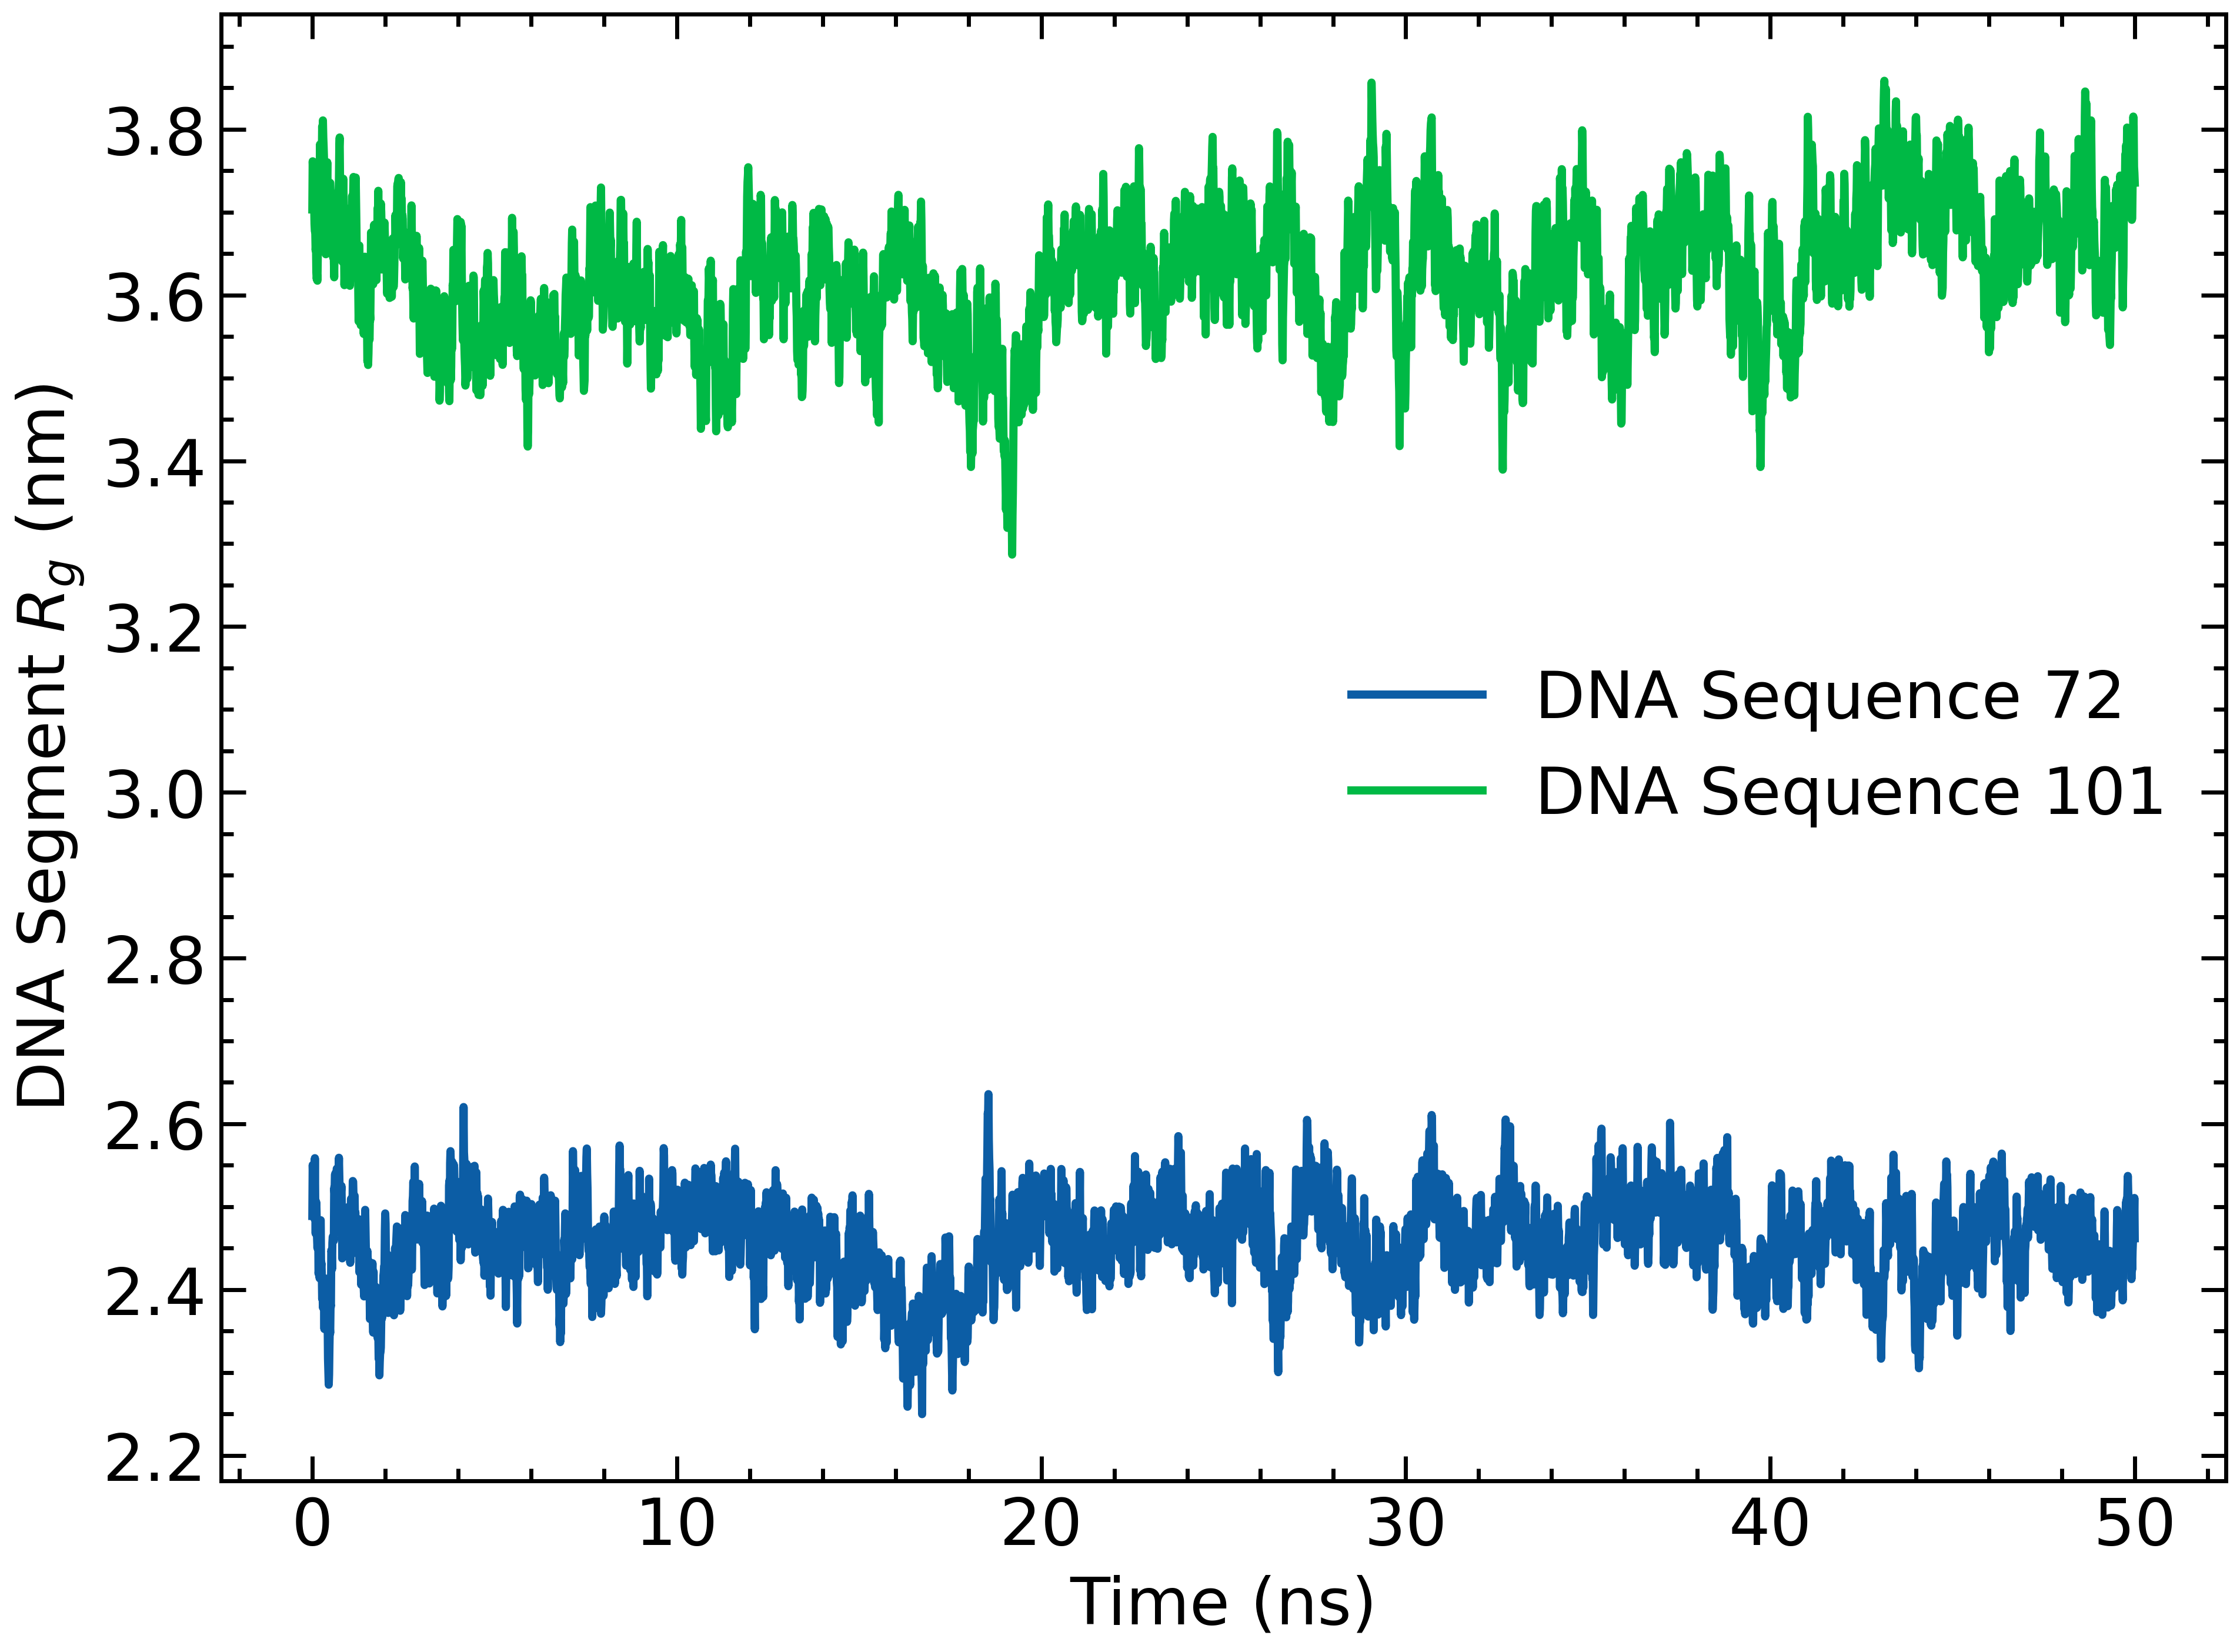

In [19]:
from tqdm.notebook import tqdm


for key, value in sims.items():
    
	group = value.select_atoms('nucleic')		# change the atom selection for your specific system

	Frame = []
	times = []
	Rgyr = []
	for ts in tqdm(value.trajectory):
		Frame.append(ts.frame)
		times.append(value.trajectory.time)
		Rgyr.append(group.radius_of_gyration())

	Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
	dfs[key] = pd.concat([dfs[key], pd.DataFrame(Rgyrc_table, columns=["Rgyr frame", "Rgyr time (ps)", "Rgyr (A)"])], axis=1)
	plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, label=f'DNA Sequence {key}')

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel(r'DNA Segment $R_g$ (nm)')
plt.show()

## RMSF Calculation

Between protein backbone and Carbon alphas.

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

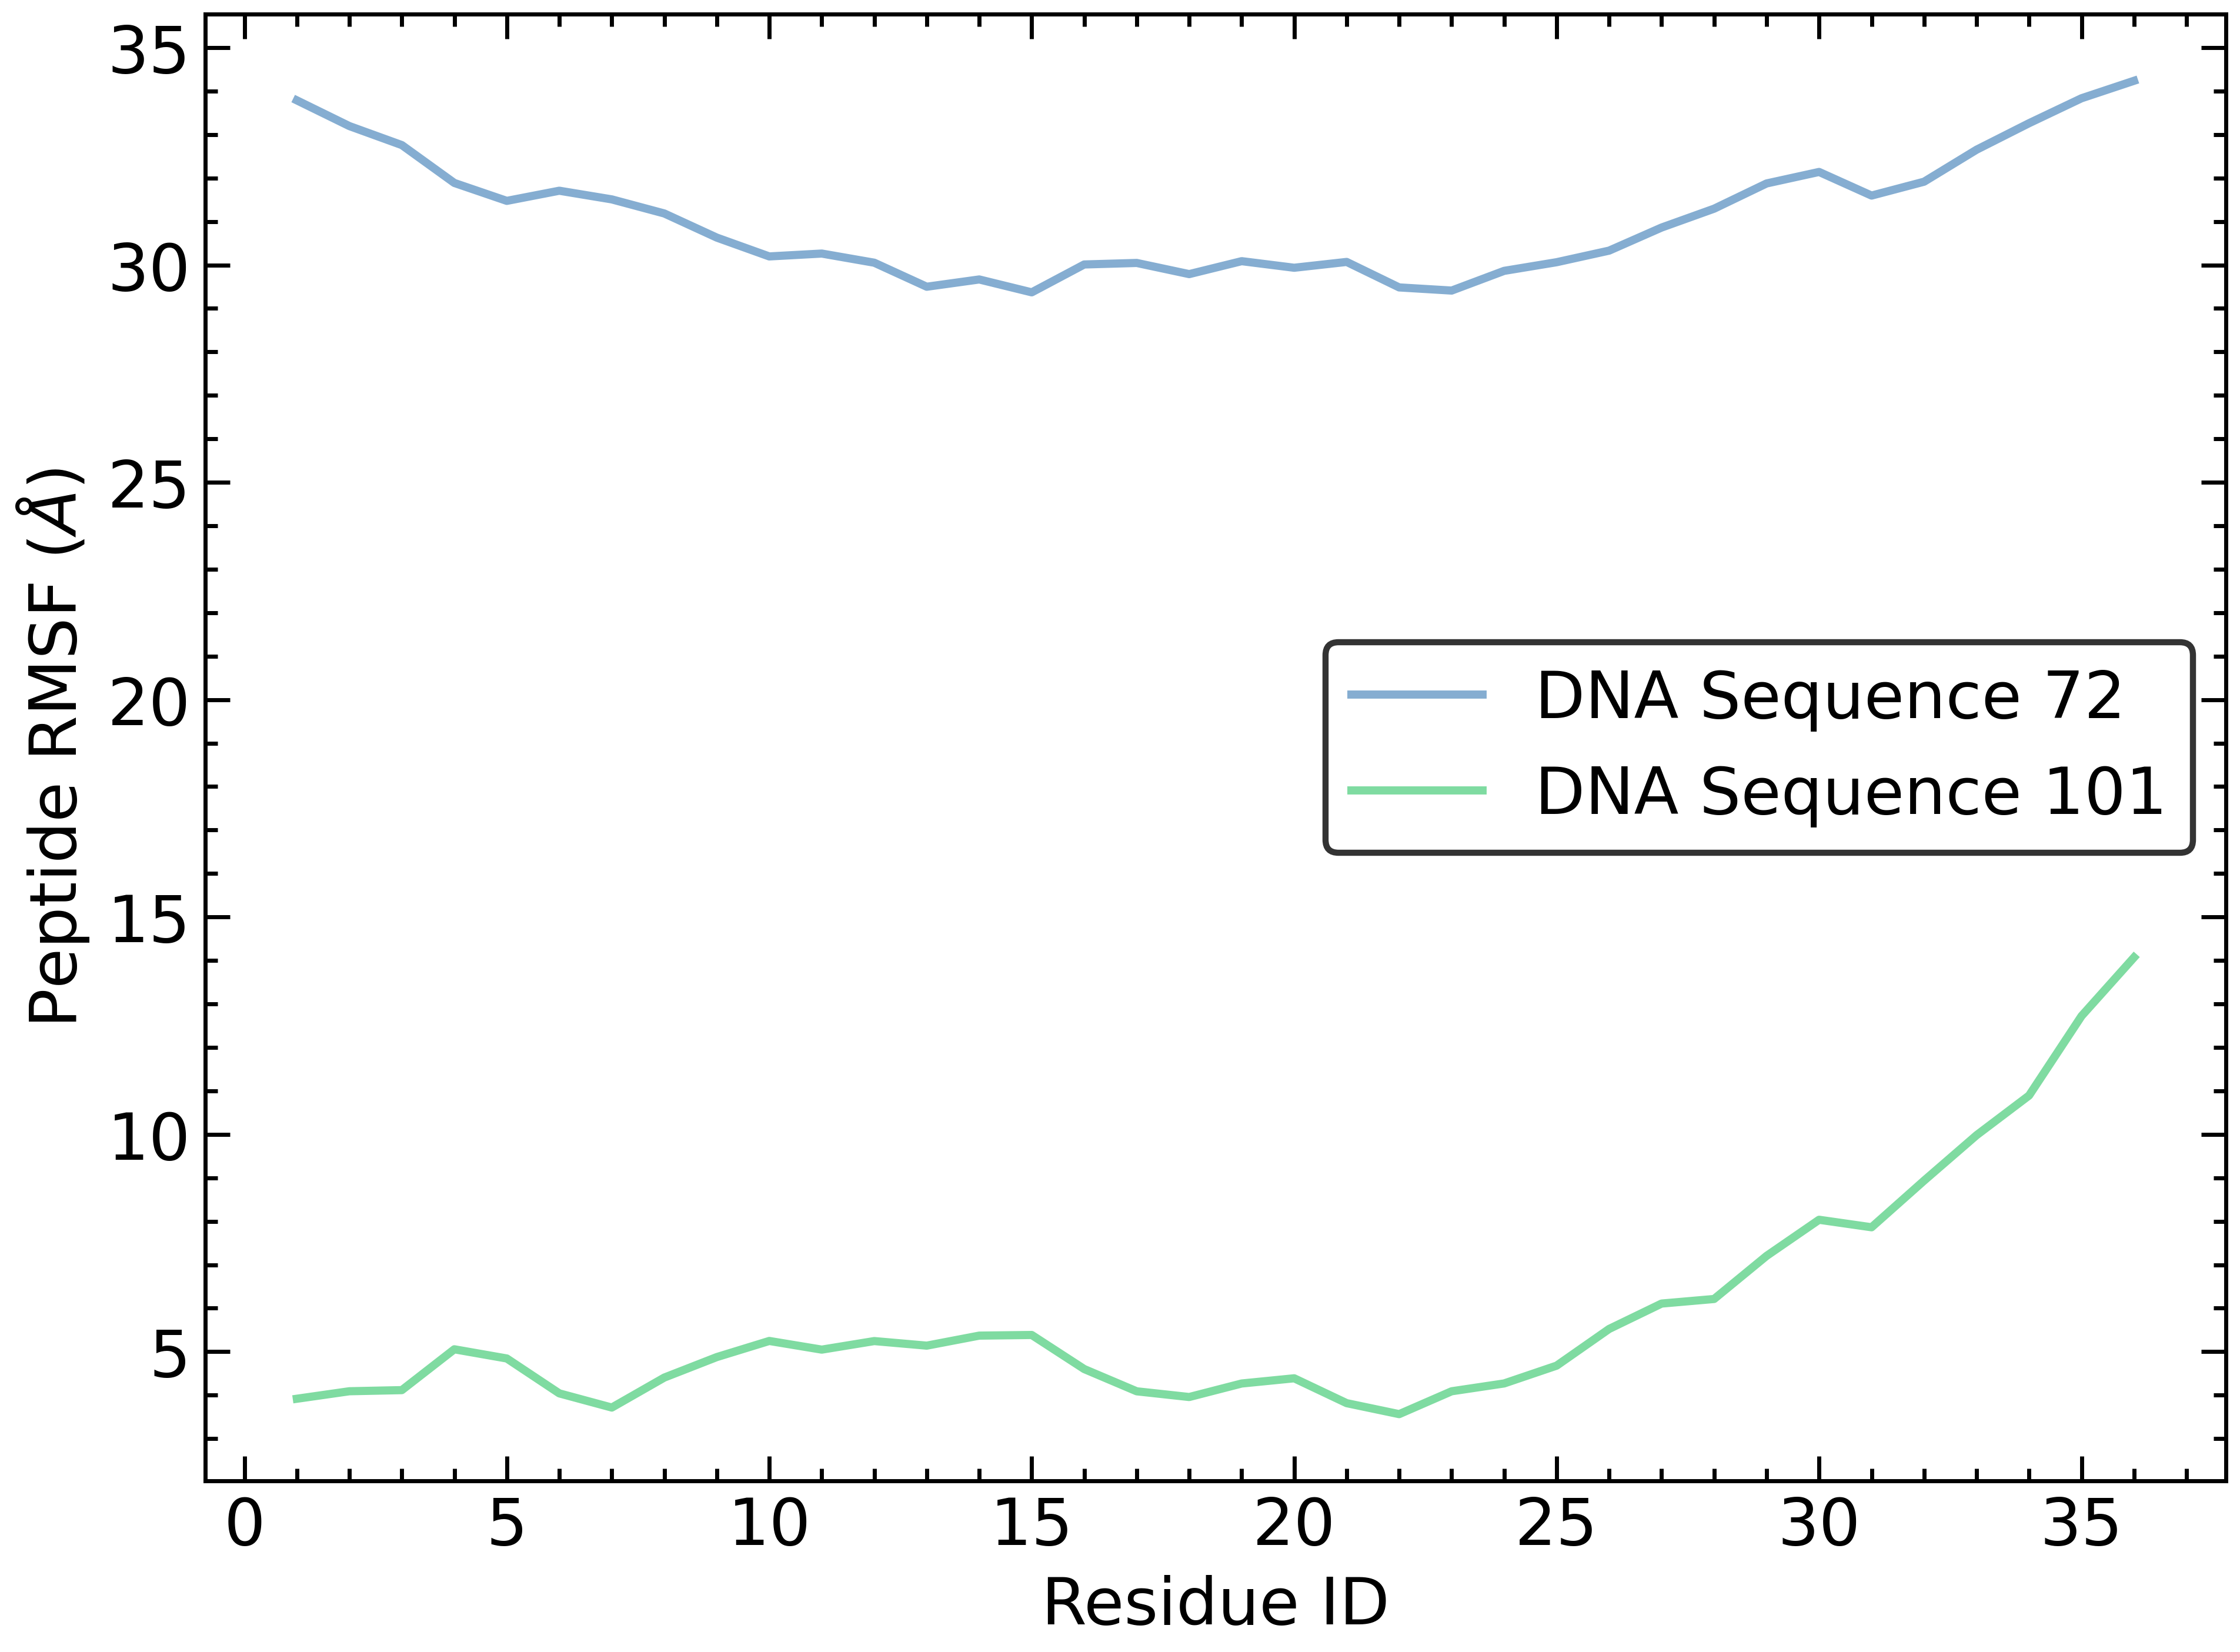

In [ ]:
from tqdm.notebook import tqdm

sims = {'72':dna_72_ku04amp01_model0, '101':dna_101_ku04amp01_model0}

for key, value in sims.items():
    
    c_alphas_c = value.select_atoms('protein and backbone and name CA')
	
    R_c = rms.RMSF(c_alphas_c).run(verbose=True)
    plt.plot(c_alphas_c.resids, R_c.results.rmsf, alpha=0.5, label=f'DNA Sequence {key}')
    dfs[key] = pd.concat([dfs[key], pd.DataFrame(np.vstack((c_alphas_c.resids, R_c.results.rmsf)).T, columns=["Resids", "RMSF (A)"])], axis=1)

plt.xlabel('Residue ID')
plt.ylabel(r'Peptide RMSF $\left(\AA\right)$')
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.5)

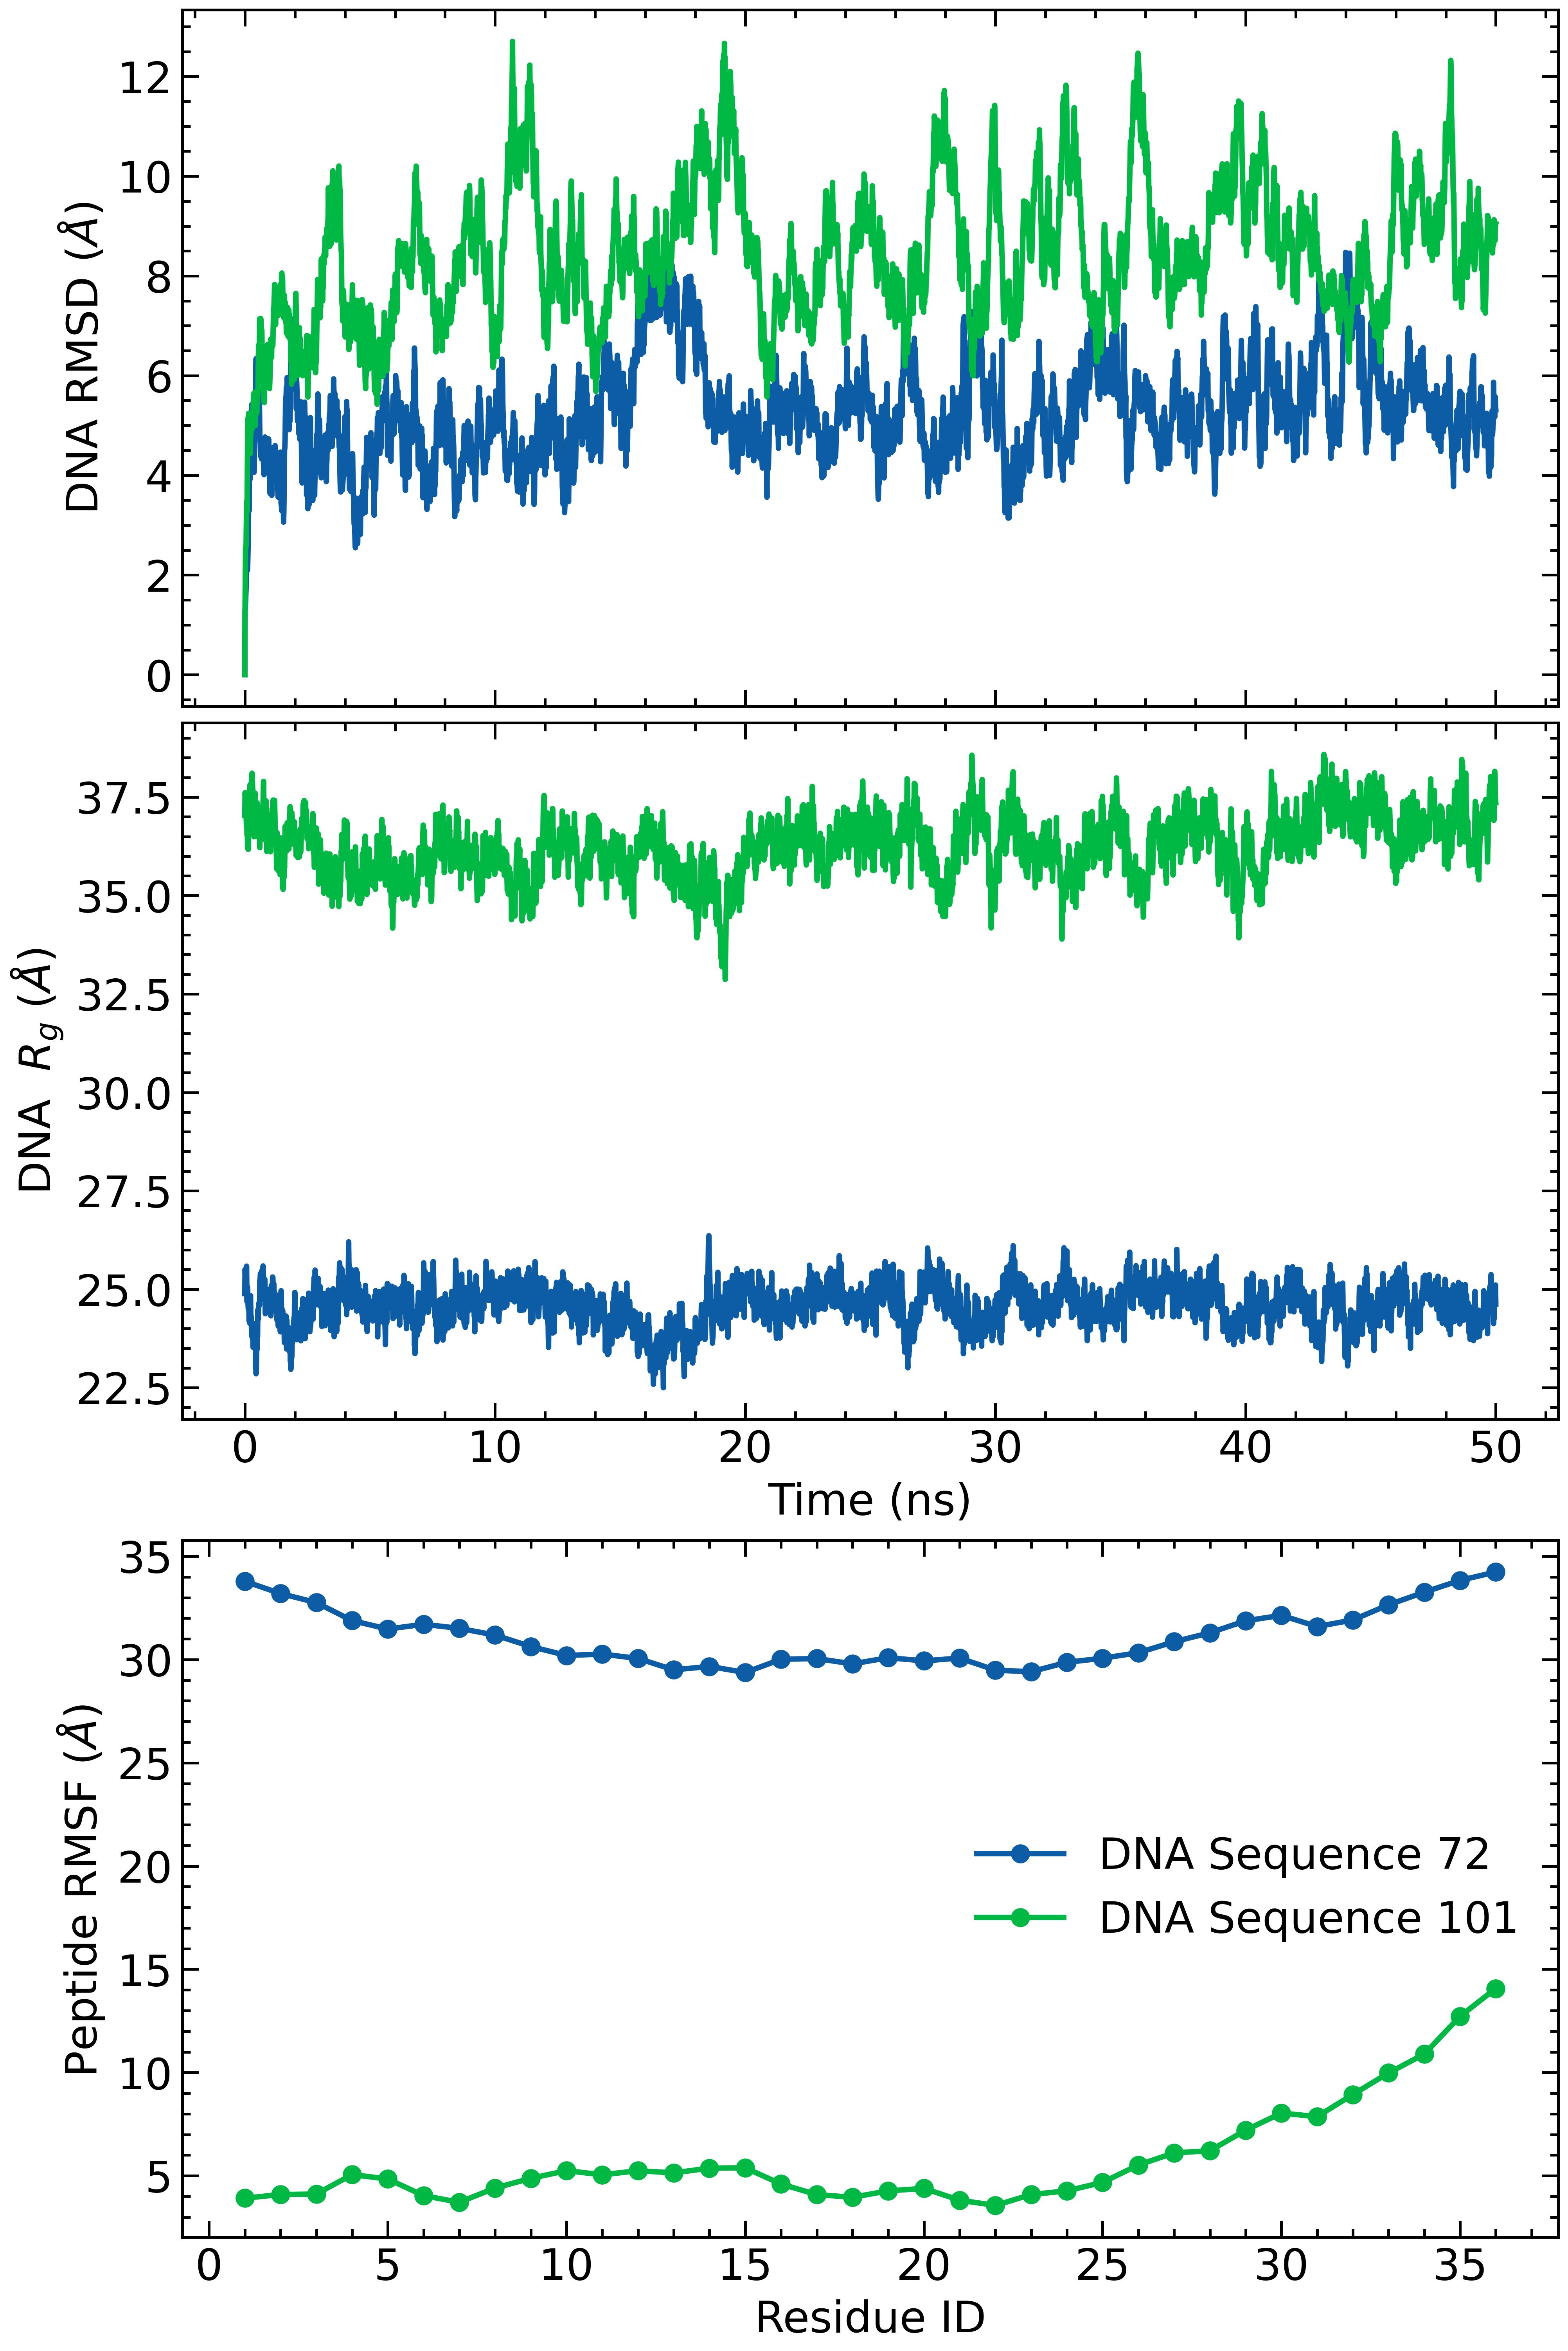

In [30]:
# Use the dataframe for simulation '101'
df = dfs['101']

fig, axs = plt.subplots(3, 1, figsize=(8, 12), constrained_layout=True)

for key, df in dfs.items():
    # Panel 1: RMSD vs Time
    axs[0].plot(df["rmsd time"]/1000, df["rmsd"], label=f"DNA Sequence {key}")
    axs[0].set_ylabel(r"DNA RMSD $\left(\AA\right)$")
    axs[0].set_xticklabels([])
    #axs[0].legend()

    # Panel 2: Radius of Gyration vs Time
    axs[1].plot(df["Rgyr time (ps)"] / 1000, df["Rgyr (A)"], label=f"DNA Sequence {key}")
    axs[1].set_xlabel("Time (ns)")
    axs[1].set_ylabel(r"DNA  $R_g\; \left(\AA\right)$")
    #axs[1].legend()

    # Panel 3: RMSF vs Residues
    # Only non-null rows are plotted (RMSF was added for about 36 residues)
    rmsf_data = df[["Resids", "RMSF (A)"]].dropna()
    axs[2].plot(rmsf_data["Resids"], rmsf_data["RMSF (A)"], marker='o', linestyle='-', label=f"DNA Sequence {key}")
    axs[2].set_xlabel("Residue ID")
    axs[2].set_ylabel(r"Peptide RMSF $\left(\AA\right)$ ")
    axs[2].legend()
    
plt.savefig('dna_sequence_72_101_peptide_model_0.png', dpi=600)

plt.show()